In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modeling and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
)

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Handling class imbalance
from imblearn.over_sampling import SMOTE

# Interpretability
import shap

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Visual style
sns.set(style='whitegrid')
%matplotlib inline


In [2]:
# Loading our cleaned CSV for EDA and modeling
df = pd.read_csv("C:/Users/user/Downloads/adult/adult_combined.csv")

# Preview the data
df.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,source,is_high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,train,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train,0


## Data Loading, Merging, and Initial Labeling

In [3]:
import pandas as pd

# Column names
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

# Load raw train and test data
df_train = pd.read_csv(
    "C:/Users/user/Downloads/adult/adult.csv",
    names=columns,
    header=None,
    skipinitialspace=True,
    na_values="?"
)

df_test = pd.read_csv(
    "C:/Users/user/Downloads/adult/adult_test.csv",
    names=columns,
    header=None,
    skiprows=1,
    skipinitialspace=True,
    na_values="?"
)

# Clean test target
df_test["income"] = df_test["income"].str.replace(".", "", regex=False).str.strip()

# Label sources
df_train["source"] = "train"
df_test["source"] = "test"

# Combining both of them
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Creating binary targets
df_combined['is_high_income'] = (df_combined['income'] == '>50K').astype(int)
print("'is_high_income' column created in df_combined.")

# Saving the file
df_combined.to_csv("C:/Users/user/Downloads/adult/adult_combined.csv", index=False)
print("df_combined saved with 'is_high_income'. Ready for cleaning and EDA.")

# Preview
df_combined.head()


'is_high_income' column created in df_combined.
df_combined saved with 'is_high_income'. Ready for cleaning and EDA.


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,source,is_high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,train,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train,0


In [4]:
df_combined.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,is_high_income
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


## Data Cleaning and Feature Engineering

In [5]:
# Load combined file
df_combined = pd.read_csv("C:/Users/user/Downloads/adult/adult_combined.csv")

# Strip whitespace in object columns
obj_cols = df_combined.select_dtypes(include='object').columns
df_combined[obj_cols] = df_combined[obj_cols].apply(lambda x: x.str.strip())

# Drop missing values
df_combined.dropna(inplace=True)

# Ensuring 'age' is numeric
df_combined['age'] = pd.to_numeric(df_combined['age'], errors='coerce')
df_combined.dropna(subset=['age'], inplace=True)

# Bin age
bins = [16, 30, 45, 60, 100]
labels = ['18-30', '31-45', '46-60', '60+']
df_combined['age_group'] = pd.cut(df_combined['age'].astype(int), bins=bins, labels=labels)

# One-hot encode categorical variables
categorical_cols = [
    'workclass', 'education', 'marital_status', 'occupation',
    'relationship', 'race', 'sex', 'native_country', 'age_group'
]
df_combined = pd.get_dummies(df_combined, columns=categorical_cols, drop_first=True)

# Droping unused columns
df_combined.drop(['income', 'source'], axis=1, inplace=True)

# Save cleaned dataset
df_combined.to_csv("C:/Users/user/Downloads/adult/adult_combined_cleaned.csv", index=False)
print("Cleaning complete. Saved as 'combined_cleaned.csv'. Ready for EDA and modeling.")

# Preview
df_combined.head()


Cleaning complete. Saved as 'combined_cleaned.csv'. Ready for EDA and modeling.


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,is_high_income,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,age_group_31-45,age_group_46-60,age_group_60+
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,True,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,True,False,False,False,True,False
2,38,215646,9,0,0,40,0,False,True,False,...,False,False,False,False,True,False,False,True,False,False
3,53,234721,7,0,0,40,0,False,True,False,...,False,False,False,False,True,False,False,False,True,False
4,28,338409,13,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# Creating Quartile-Based Bins

# Create 4 quantile-based age bins
df_combined['age_bin'] = pd.qcut(df_combined['age'], q=4, labels=False)

# To see distribution:
print(df_combined['age_bin'].value_counts()) 


age_bin
0    11888
1    11139
3    11135
2    11060
Name: count, dtype: int64


In [7]:
# Employing Polynomial Features from sklearn for numeric columns:

from sklearn.preprocessing import PolynomialFeatures

# Select numeric features only
numeric_features = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

X_poly = poly.fit_transform(df_combined[numeric_features])
poly_feature_names = poly.get_feature_names_out(numeric_features)

# Create a DataFrame for easy integration
df_poly = pd.DataFrame(X_poly, columns=poly_feature_names)

# Combine with other features if needed
df_combined_poly = pd.concat([df_combined.reset_index(drop=True), df_poly.reset_index(drop=True)], axis=1)


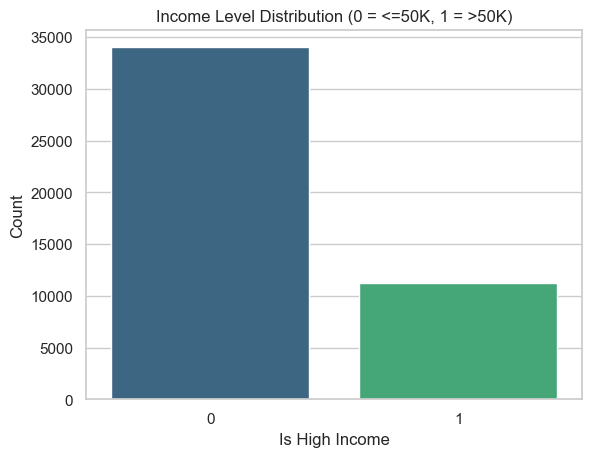

In [8]:
# Countplot of target
sns.countplot(x='is_high_income', data=df_combined, palette='viridis')
plt.title('Income Level Distribution (0 = <=50K, 1 = >50K)')
plt.xlabel('Is High Income')
plt.ylabel('Count')
plt.show()


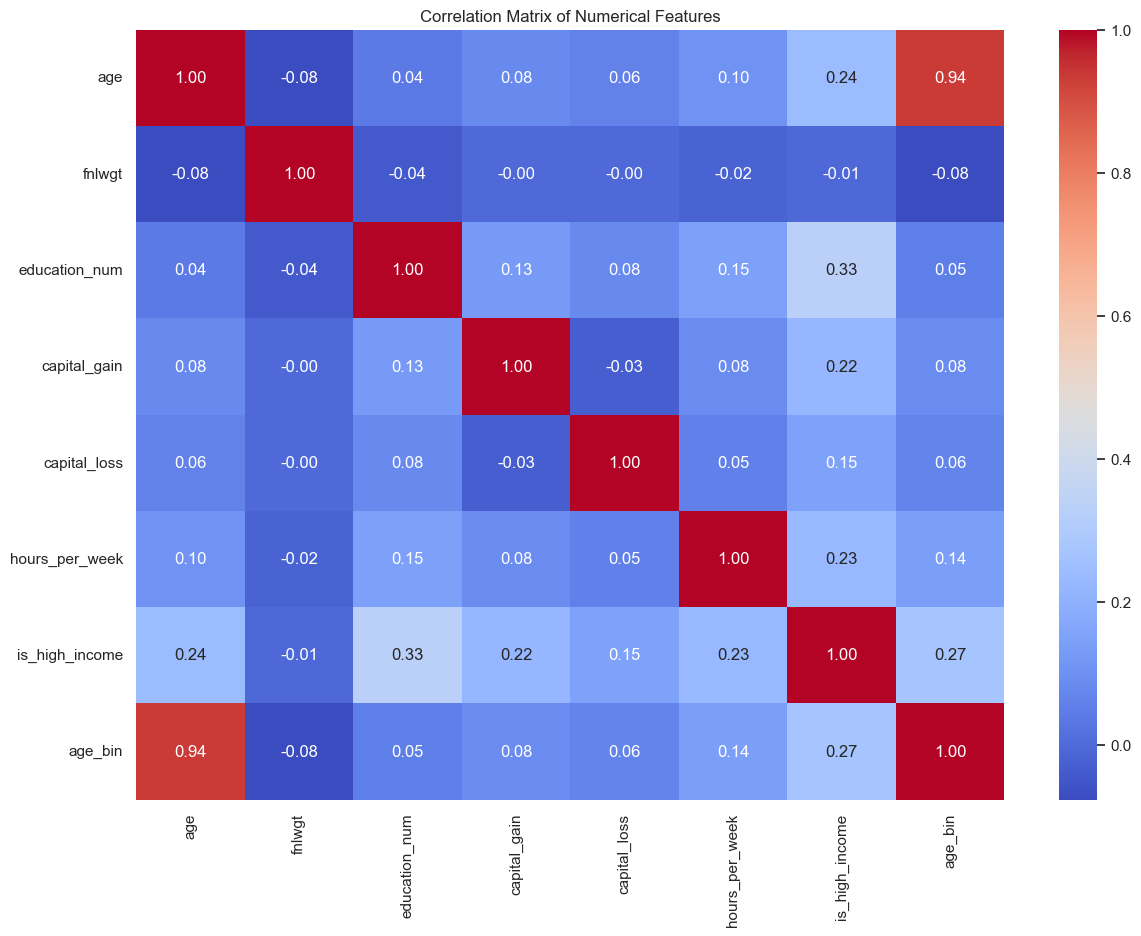

In [9]:
numeric_df = df_combined.select_dtypes(include='number')
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

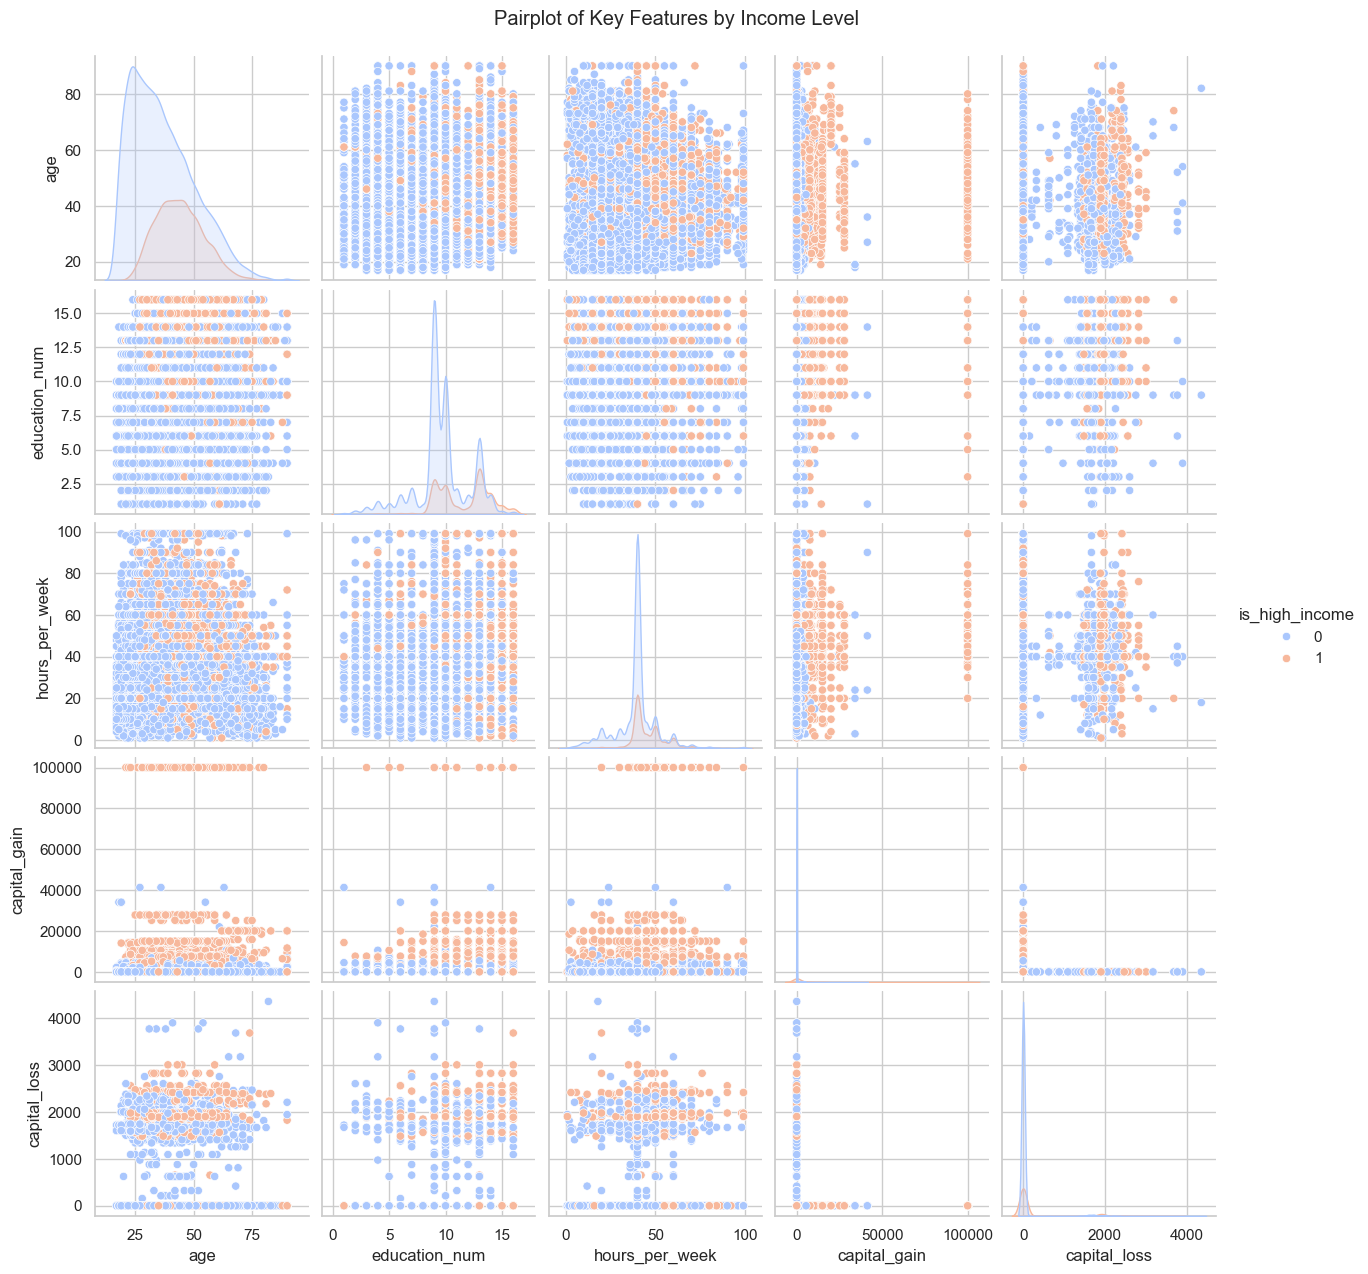

In [10]:
# Pairplot
selected_features = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss', 'is_high_income']
sns.pairplot(df_combined[selected_features], hue='is_high_income', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairplot of Key Features by Income Level', y=1.02)
plt.show()

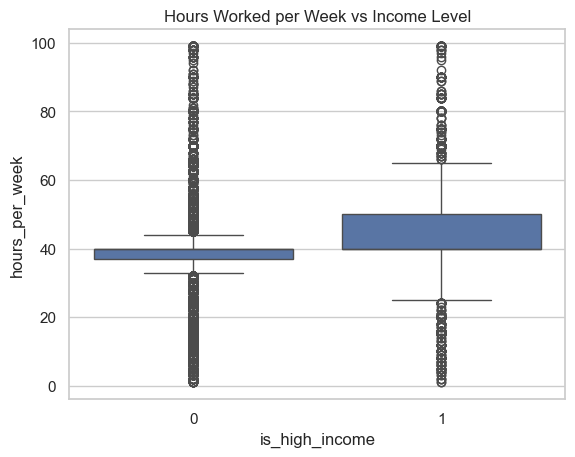

In [11]:
# Boxplots
sns.boxplot(x='is_high_income', y='hours_per_week', data=df_combined)
plt.title('Hours Worked per Week vs Income Level')
plt.show()

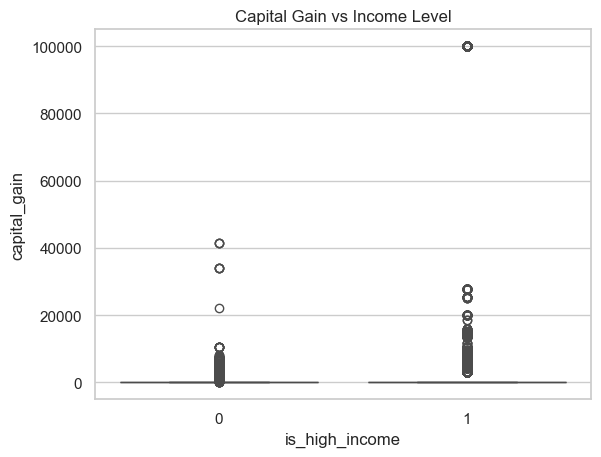

In [12]:
# Capital Gains vs Income Level

sns.boxplot(x='is_high_income', y='capital_gain', data=df_combined)
plt.title('Capital Gain vs Income Level')
plt.show()

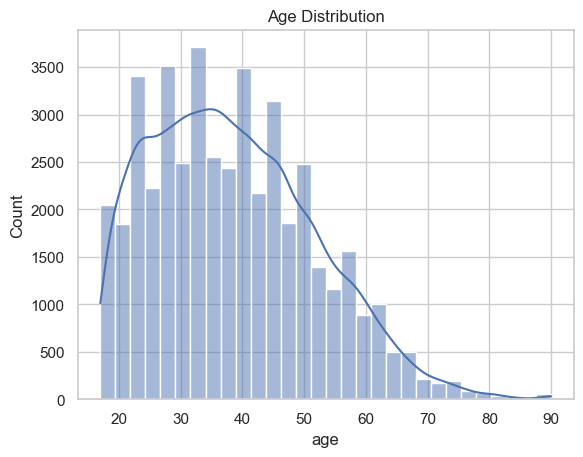

In [13]:
# Histograms
sns.histplot(df_combined['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

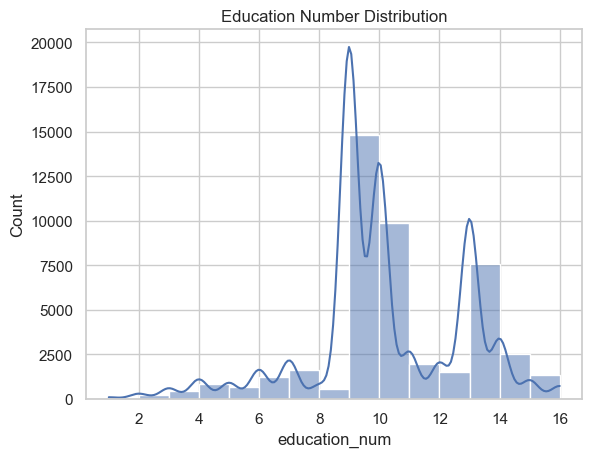

In [14]:
# Education Number Distribution

sns.histplot(df_combined['education_num'], bins=15, kde=True)
plt.title('Education Number Distribution')
plt.show()

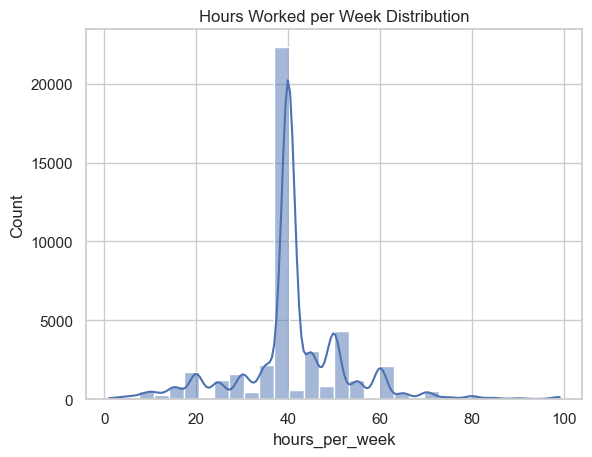

In [15]:
# Hours Worked per Week Distribution

sns.histplot(df_combined['hours_per_week'], bins=30, kde=True)
plt.title('Hours Worked per Week Distribution')
plt.show()


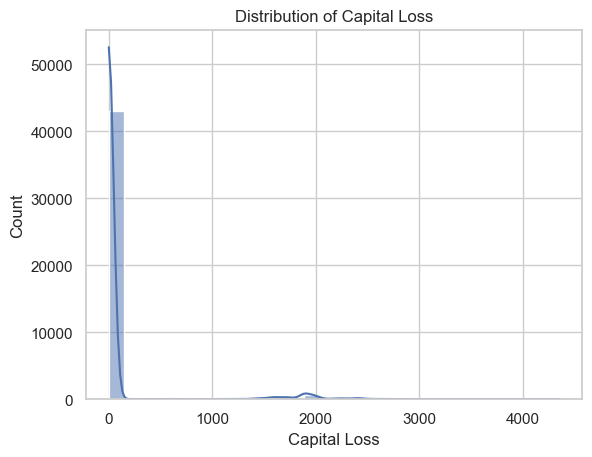

In [16]:
# Visualizing Capital_loss Distribution

sns.histplot(df_combined['capital_loss'], bins=30, kde=True)
plt.title('Distribution of Capital Loss')
plt.xlabel('Capital Loss')
plt.ylabel('Count')
plt.show()


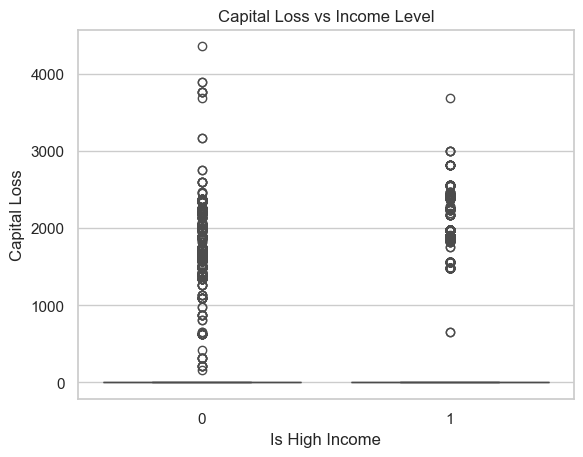

In [17]:
# Uiing Boxplot to visualize Capital_loss Distribution

sns.boxplot(x='is_high_income', y='capital_loss', data=df_combined)
plt.title('Capital Loss vs Income Level')
plt.xlabel('Is High Income')
plt.ylabel('Capital Loss')
plt.show()


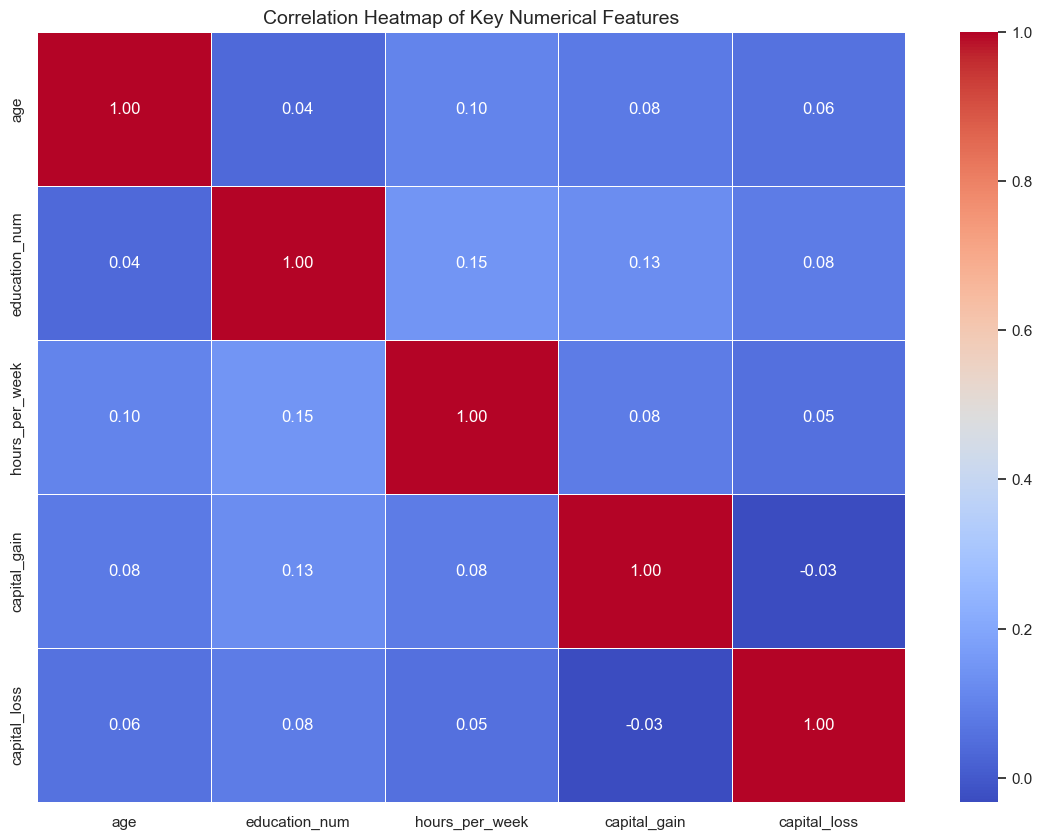

In [18]:
# Correlation Heatmaps of Key Numerical Features

import matplotlib.pyplot as plt
import seaborn as sns

# Selecting only key numerical features for clarity
key_features = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']

# Computing correlation matrix on these only
corr_matrix_small = df_combined[key_features].corr()

# Finally we plotted the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_small, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap of Key Numerical Features", fontsize=14)
plt.show()


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      6803
           1       0.69      0.64      0.66      2242

    accuracy                           0.84      9045
   macro avg       0.79      0.77      0.78      9045
weighted avg       0.84      0.84      0.84      9045

ROC-AUC: 0.896707328442888


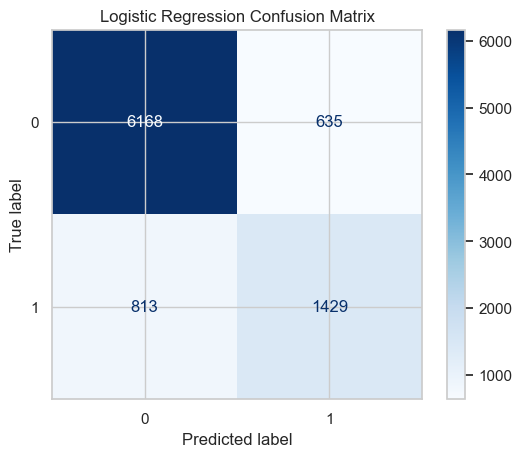

Random Forest Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6803
           1       0.71      0.65      0.68      2242

    accuracy                           0.85      9045
   macro avg       0.80      0.78      0.79      9045
weighted avg       0.84      0.85      0.84      9045

ROC-AUC: 0.8957391154634382


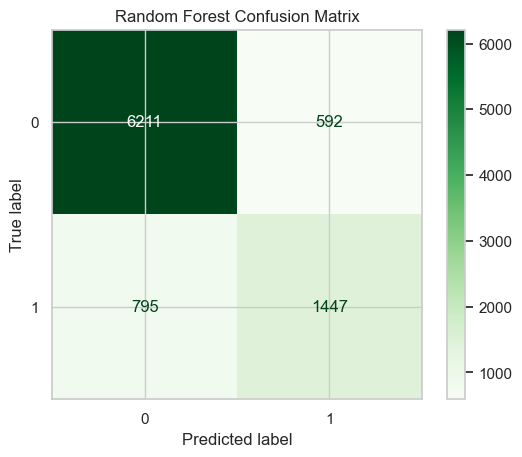

In [19]:
# Modeling Block

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import shap

# Split features and target
X = df_combined.drop('is_high_income', axis=1)
y = df_combined['is_high_income']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handling imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)
y_pred_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_lr))

ConfusionMatrixDisplay.from_estimator(lr, X_test_scaled, y_test, cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_rf))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.show()


In [20]:
# Training and Tuning XGBoost classifier 

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit the model on your SMOTE-resampled training data
grid_search_xgb.fit(X_train_res, y_train_res)

# Extract the best estimator for use in SHAP
best_xgb = grid_search_xgb.best_estimator_

# Optional: Evaluate quickly
print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best XGBoost ROC-AUC (CV):", grid_search_xgb.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best XGBoost ROC-AUC (CV): 0.9684086892060562


X_test_clean is fully numeric and ready for SHAP. Shape: (9045, 100)


100%|===================| 18085/18090 [43:06<00:00]        

SHAP values computed successfully.


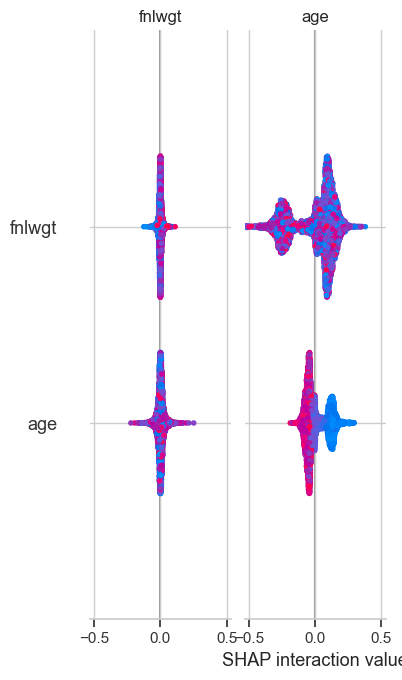

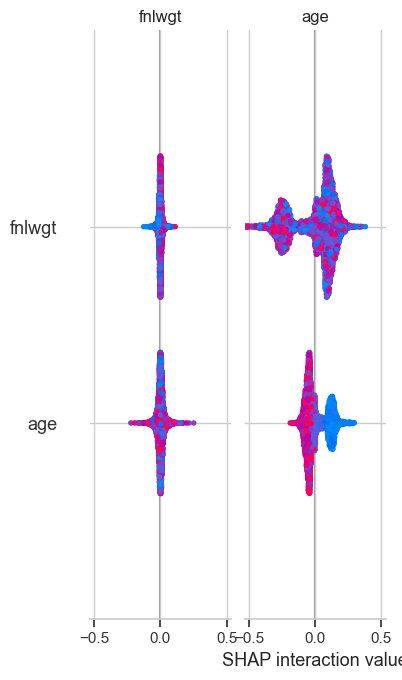

In [21]:
import shap

# Ensuring X_test is fully numeric
object_columns = X_test.columns[X_test.dtypes == 'object']
if len(object_columns) > 0:
    print("Fixing object columns:", object_columns.tolist())
    for col in object_columns:
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Dropping rows with NaNs after coercion
X_test_clean = X_test.dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# Force dtype to float to ensure SHAP compatibility
X_test_clean = X_test_clean.astype(float)

print("X_test_clean is fully numeric and ready for SHAP. Shape:", X_test_clean.shape)

# Initializing SHAP Explainer
explainer = shap.Explainer(rf, X_test_clean)

# Compute SHAP values
shap_values = explainer(X_test_clean)

print("SHAP values computed successfully.")

# Plot SHAP bar plot
shap.summary_plot(shap_values, X_test_clean, plot_type="bar")

# Plot SHAP beeswarm plot
shap.summary_plot(shap_values, X_test_clean)


In [22]:
from xgboost import XGBClassifier

# Initialize XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit on training data
xgb.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_xgb))


XGBoost Results:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      6803
           1       0.75      0.67      0.71      2242

    accuracy                           0.86      9045
   macro avg       0.82      0.80      0.81      9045
weighted avg       0.86      0.86      0.86      9045

ROC-AUC Score: 0.9207853280870079


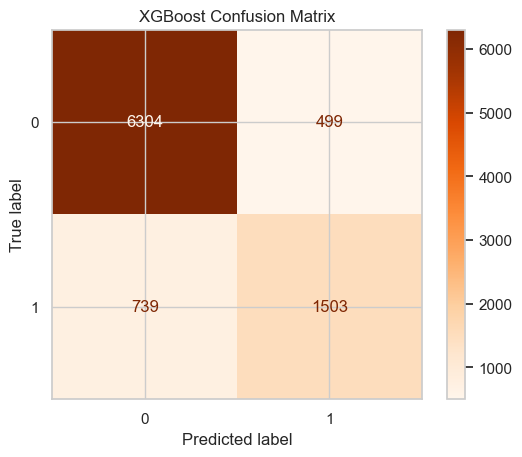

In [23]:
# Confusion matrix visualization for XGBoost:

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.show()

 99%|===================| 8929/9045 [00:30<00:00]        

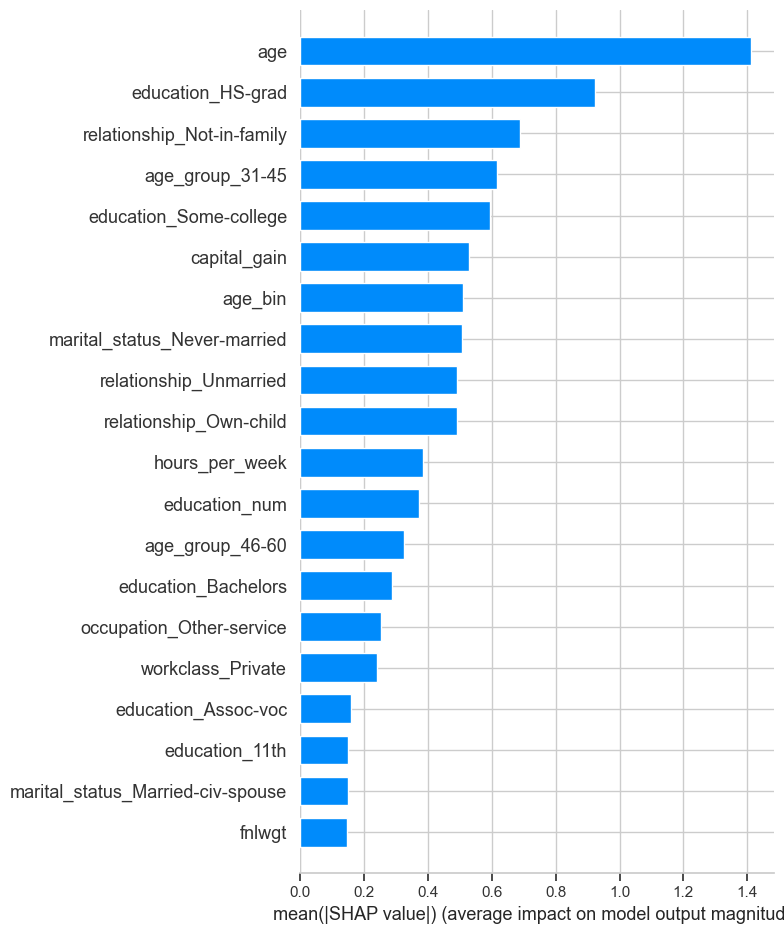

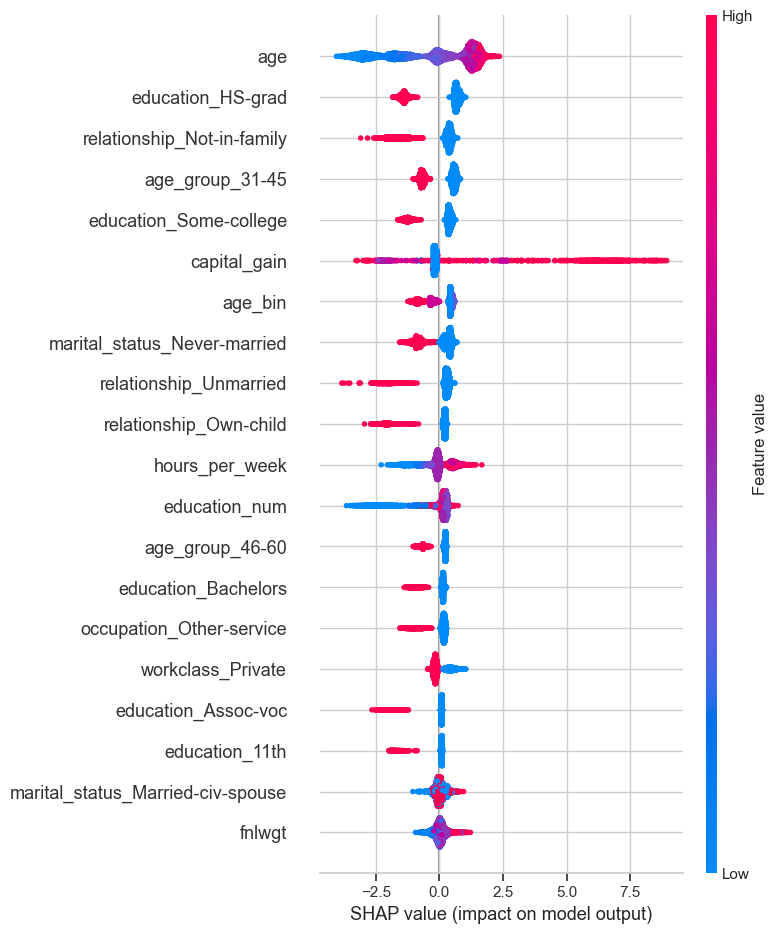

In [24]:
# SHAP Beeswarm Plot showing the Interpretability of SHAP

explainer = shap.Explainer(xgb, X_test.astype(float))
shap_values = explainer(X_test.astype(float))

shap.summary_plot(shap_values, X_test.astype(float), plot_type="bar")
shap.summary_plot(shap_values, X_test.astype(float))



## The SHAP beeswarm plot allowed us to visualize the distribution and directionality of each feature’s impact on individual predictions. We observed that features like education_num, capital_gain, and hours_per_week consistently push predictions toward higher income when their values are high, while low values push predictions toward lower income. This visual reinforced the interpretability of our XGBoost model and provided actionable insights on how specific attributes influence income levels.

## Red dots (high feature values) on the right side show pushing predictions toward >50K.

## Blue dots (low feature values) on the left side show pushing predictions toward <=50K

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

lr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_

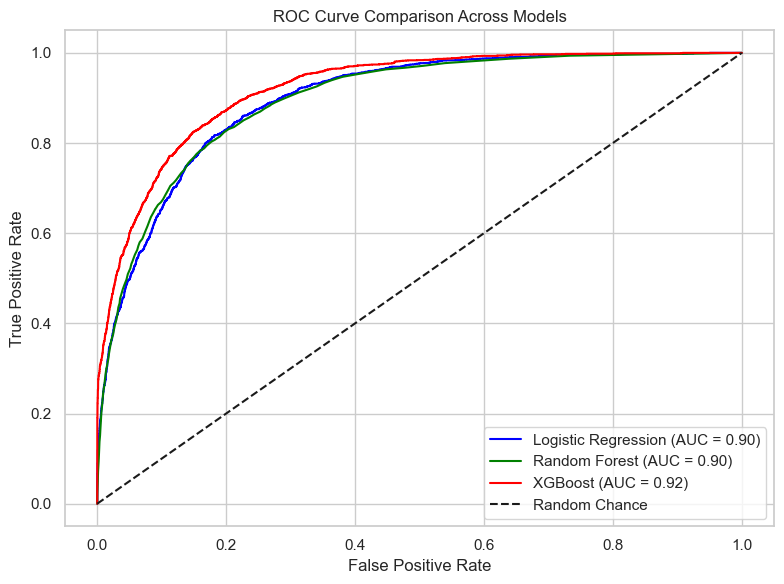

In [26]:
# ROC Comparison Plot

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', color='blue')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='green')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', color='red')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison Across Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Best XGBoost ROC-AUC (CV): 0.9718243787433616
Tuned XGBoost Test Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      6803
           1       0.74      0.67      0.71      2242

    accuracy                           0.86      9045
   macro avg       0.82      0.80      0.81      9045
weighted avg       0.86      0.86      0.86      9045

Tuned XGBoost ROC-AUC (Test): 0.9215609802727793


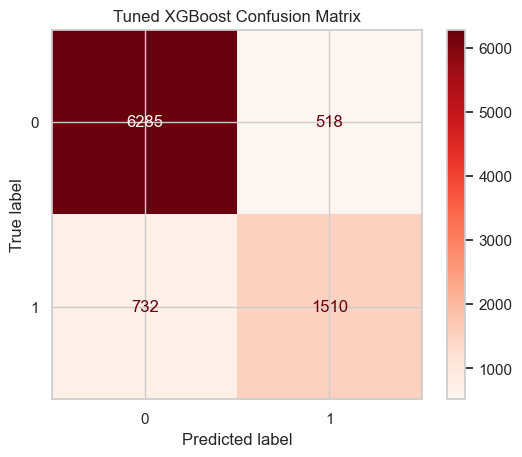

In [27]:
# XGBoost Hyperparameter Tuning Block

from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search_xgb = GridSearchCV(estimator=xgb_model,
                                param_grid=param_grid_xgb,
                                scoring='roc_auc',
                                cv=5,
                                n_jobs=-1,
                                verbose=2)

grid_search_xgb.fit(X_train_res, y_train_res)

best_xgb = grid_search_xgb.best_estimator_

print("Best XGBoost Parameters:", grid_search_xgb.best_params_)
print("Best XGBoost ROC-AUC (CV):", grid_search_xgb.best_score_)

# Evaluate on test data
y_pred_xgb_best = best_xgb.predict(X_test)
y_pred_prob_xgb_best = best_xgb.predict_proba(X_test)[:, 1]

print("Tuned XGBoost Test Report:")
print(classification_report(y_test, y_pred_xgb_best))
print("Tuned XGBoost ROC-AUC (Test):", roc_auc_score(y_test, y_pred_prob_xgb_best))

ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, cmap='Reds')
plt.title("Tuned XGBoost Confusion Matrix")
plt.show()


In [28]:
# Dropping Low Important Features

importances = rf.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importance_df.head(10))


                              Feature  Importance
0                                 age    0.106592
1                              fnlwgt    0.091032
30       marital_status_Never-married    0.071045
5                      hours_per_week    0.070212
2                       education_num    0.064935
46         relationship_Not-in-family    0.059220
28  marital_status_Married-civ-spouse    0.057663
3                        capital_gain    0.053604
22                  education_HS-grad    0.043443
99                            age_bin    0.036259


In [29]:
# Recursive Feature Elimination (RFE

from sklearn.feature_selection import RFE

selector = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)
selector.fit(X_train_scaled, y_train_res)

selected_features = X_train.columns[selector.support_]
print(selected_features)


Index(['education_num', 'capital_gain', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors', 'education_HS-grad',
       'education_Masters', 'education_Some-college',
       'relationship_Not-in-family', 'relationship_Own-child'],
      dtype='object')


              precision    recall  f1-score   support

           0       0.90      0.92      0.91      6803
           1       0.74      0.67      0.71      2242

    accuracy                           0.86      9045
   macro avg       0.82      0.80      0.81      9045
weighted avg       0.86      0.86      0.86      9045

Test ROC-AUC Score: 0.9215609802727793


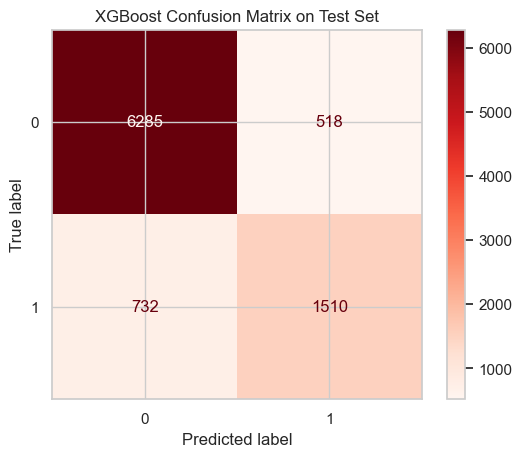

In [30]:
# Test Evaluation

y_pred_xgb = best_xgb.predict(X_test_clean)
y_pred_prob_xgb = best_xgb.predict_proba(X_test_clean)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred_xgb))
print("Test ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_xgb))

ConfusionMatrixDisplay.from_estimator(best_xgb, X_test_clean, y_test, cmap='Reds')
plt.title("XGBoost Confusion Matrix on Test Set")
plt.show()
